In [306]:
# Imports

# pandas
import pandas as pd
from pandas import Series,DataFrame
pd.options.display.max_colwidth=100
    
from IPython.display import display

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier

In [307]:
# utility class to draw random numbers from given histogram
# adapted from example at http://stackoverflow.com/questions/21100716/fast-arbitrary-distribution-random-sampling
# example usage
# histo2d,xed, yed, img =plt.hist2d(train['Survived'],train['Pclass'],bins=(2,len(np.unique(train['Pclass']))),cmap=plt.cm.jet)
# dist1=RandomSample(histogram=histo2d, edges=np.array((xed,yed)))
# test=dist1(n_samples=891,seed=0)
# xy= np.transpose(test)
# histo2d_2,xed, yed, img_2=plt.hist2d(xy[0],xy[1],bins=[xed,yed],cmap=plt.cm.jet)

class RandomSample(object):
    def __init__(self, histogram, edges=None):
        # edges contains bin edges along the dimensions
        self.edges=edges
 
        # cache shape of PDF (could be multi-D)
        
        self.originalshape=histogram.shape
        # now flatten the histogram
        # this removes the index information (e.g. the bin limits) from here on, we only know (and return) index position, not label
        self.pdf=histogram.ravel()
        # sanity check
        assert(np.all(histogram>=0))
        
        # numerical stability in cumulative pdf: sort by magnitude
        self.sortindex = np.argsort(self.pdf, axis=None)
        self.pdf = self.pdf[self.sortindex]

        # compute the cumulative distribution function
        self.cdf = np.cumsum(self.pdf)
        
    def __call__(self, n_samples, seed=0):
        #pick numbers which are uniformly random over the cumulative distribution function
        # note that the histo does not need to be normalized
        np.random.seed(seed)
        choice = np.random.uniform(high = self.cdf[-1], size = n_samples)
        print "chose events"
        # where are these points in cumulative?
        # this returns a list of indices corresponding to the numbers we extracted
        index = np.searchsorted(self.cdf, choice)

        # go back to original indices, i.e. revert the ordering
        # note: the values of sortindex are old indices, the indices are the new indices
        index = self.sortindex[index]
        # go back to multi-dimensional indexing
        index = np.unravel_index(index, self.originalshape)
        # the line above gave one tuple per axis, i.e. all x-indices in one tuple, all y indices in a second tuple, and so on
        # we stack them before returning
        index=np.vstack(index)
        if self.edges==None:
            # no edges given, return indices
            # result are indices (on axis=1) for each original coordinate (axis=0)
            return index
        # we have edges, can convert indices to bin centers
        result=[]
        for coord in np.transpose(index):
            thispoint=[]
            for i,x in enumerate(coord):
                lower=self.edges[i][x]
                upper=self.edges[i][x+1]
                thispoint.append(np.random.uniform(lower,upper))
            result.append(thispoint)
        return result

In [308]:
# read the test and train samples in a csv

train = pd.read_csv("train.csv")
test  = pd.read_csv("test.csv")

# drop Name, passId, ticket. keep oassId in test for the solution

if 'Name' in train.columns:
    del train['Name']
    del test['Name']
if 'PassengerId' in train.columns:
    del train['PassengerId']
if 'Ticket' in train.columns:
    del train['Ticket']
    del test['Ticket']
if 'Cabin' in train.columns:
    del train['Cabin']
    del test['Cabin']

print(train.columns)
print test.columns

Index([u'Survived', u'Pclass', u'Sex', u'Age', u'SibSp', u'Parch', u'Fare',
       u'Embarked'],
      dtype='object')
Index([u'PassengerId', u'Pclass', u'Sex', u'Age', u'SibSp', u'Parch', u'Fare',
       u'Embarked'],
      dtype='object')


In [309]:
# check contents of columns
#for col in train.columns:
#    print("Value counts for column {}".format(col))
#    print(train[col].value_counts(dropna=False))
    
# column train.Embarked has two NaNs, fill with most common value

train.Embarked.fillna(value='S', inplace=True)
#train.Age.fillna(value=train.Age.mean(),inplace=True)
# tranform sex and Embarked columns
test.Embarked.fillna(value='S', inplace=True)

train.loc[train['Sex']=='male','Sex']=1
train.loc[train['Sex']=='female','Sex']=0
train.Sex=train.Sex.astype('int32')

train.loc[train['Embarked']=='S','Embarked']=0
train.loc[train['Embarked']=='C','Embarked']=1
train.loc[train['Embarked']=='Q','Embarked']=2
train.Embarked=train.Embarked.astype(np.int32)

test.loc[test['Sex']=='male','Sex']=1
test.loc[test['Sex']=='female','Sex']=0
test.Sex=test.Sex.astype('int32')

test.loc[test['Embarked']=='S','Embarked']=0
test.loc[test['Embarked']=='C','Embarked']=1
test.loc[test['Embarked']=='Q','Embarked']=2
test.Embarked=test.Embarked.astype(np.int32)

# check contents of columns
for col in train.columns:
    print("Value counts for column {}".format(col))
    print(train[col].value_counts(dropna=False))
    


Value counts for column Survived
0    549
1    342
Name: Survived, dtype: int64
Value counts for column Pclass
3    491
1    216
2    184
Name: Pclass, dtype: int64
Value counts for column Sex
1    577
0    314
Name: Sex, dtype: int64
Value counts for column Age
NaN       177
 24.00     30
 22.00     27
 18.00     26
 28.00     25
 19.00     25
 30.00     25
 21.00     24
 25.00     23
 36.00     22
 29.00     20
 32.00     18
 26.00     18
 35.00     18
 27.00     18
 16.00     17
 31.00     17
 34.00     15
 23.00     15
 33.00     15
 20.00     15
 39.00     14
 17.00     13
 42.00     13
 40.00     13
 45.00     12
 38.00     11
 50.00     10
 2.00      10
 4.00      10
         ... 
 28.50      2
 63.00      2
 0.83       2
 30.50      2
 70.00      2
 57.00      2
 0.75       2
 13.00      2
 59.00      2
 10.00      2
 64.00      2
 40.50      2
 45.50      2
 32.50      2
 20.50      1
 24.50      1
 0.67       1
 70.50      1
 0.92       1
 74.00      1
 34.50      1
 14.50   

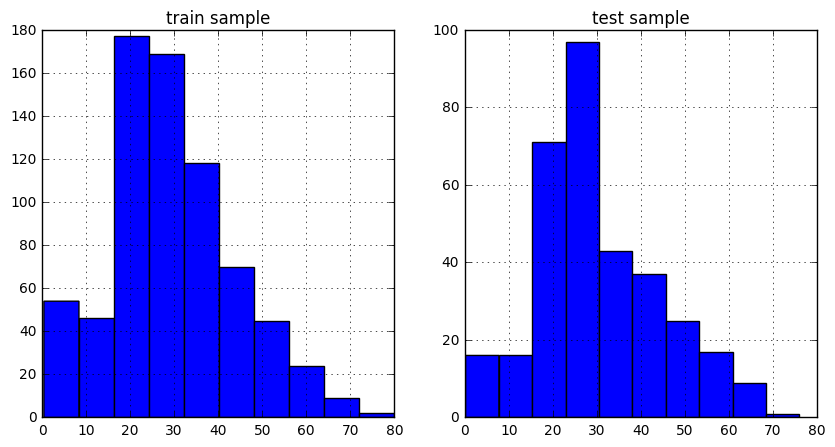

In [310]:
# age has lots of nans

# plot the original histo

f,ax=plt.subplots(1,2,figsize=(10,5))

train.Age.hist(ax=ax[0],bins=10)
ax[0].set_title("train sample")
test.Age.hist(ax=ax[1],bins=10)
ax[1].set_title("test sample")


[  0.34042   8.378    16.336    24.294    32.252    40.21     48.168
  56.126    64.084    72.042    80.     ]
(0.34, 8.378]        54
(8.378, 16.336]      46
(16.336, 24.294]    177
(24.294, 32.252]    169
(32.252, 40.21]     118
(40.21, 48.168]      70
(48.168, 56.126]     45
(56.126, 64.084]     24
(64.084, 72.042]      9
(72.042, 80]          2
Name: Age, dtype: int64
chose events
[  0.09417   7.753    15.336    22.919    30.502    38.085    45.668
  53.251    60.834    68.417    76.     ]
(0.0942, 7.753]     16
(7.753, 15.336]     16
(15.336, 22.919]    71
(22.919, 30.502]    97
(30.502, 38.085]    43
(38.085, 45.668]    37
(45.668, 53.251]    25
(53.251, 60.834]    17
(60.834, 68.417]     9
(68.417, 76]         1
Name: Age, dtype: int64
chose events


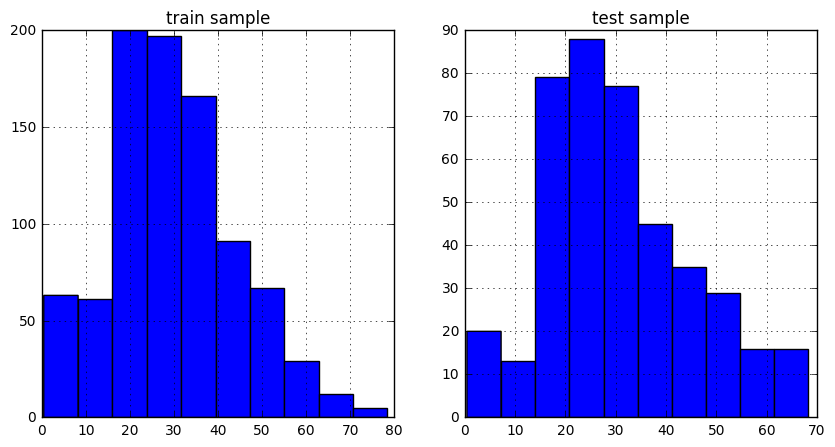

In [311]:
# generate a histogram of the age values

binned,bins=pd.cut(train['Age'],bins=10,retbins=True)

print bins
print binned.value_counts(sort=False)

#dist=RandomSample(histogram=binned.value_counts(),edges=[bins])
dist=RandomSample(histogram=binned.value_counts(sort=False),edges=[bins])

# re-generate full columns, to make things easier
fillages=dist(n_samples=len(train.Age),seed=0)

# repeat for test

binned_test,bins_test=pd.cut(test['Age'],bins=10,retbins=True)

print bins_test
print binned_test.value_counts(sort=False)

dist_test=RandomSample(histogram=binned_test.value_counts(sort=False),edges=[bins_test])

# re-generate full columns, to make things easier
fillages_test=dist_test(n_samples=len(test.Age),seed=0)


# plot the new histos

# must flatten the result, which is a list of lists
fillages_df=pd.Series(np.ravel(fillages))
fillages_df.index=train.index
fillages_test_df=pd.Series(np.ravel(fillages_test))
fillages_test_df.index=test.index

f,ax=plt.subplots(1,2,figsize=(10,5))

fillages_df.hist(bins=10,ax=ax[0])
fillages_test_df.hist(bins=10,ax=ax[1])
ax[1].set_title("test sample")
ax[0].set_title("train sample")

array([], dtype=int64)

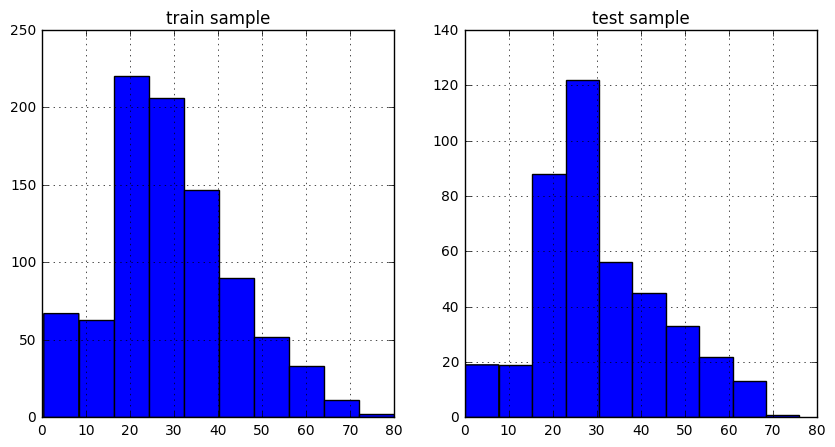

In [312]:
f,ax=plt.subplots(1,2,figsize=(10,5))

# select nans in age
mask=pd.isnull(train.Age)
train['NewAge']=train['Age'].fillna(fillages_df)
# check that shape is same
train.NewAge.hist(bins=10,ax=ax[0],figure=f)
ax[0].set_title("train sample")
# check that nans are gone
train.NewAge.value_counts(dropna=False)[np.nan]


mask_test=pd.isnull(test.Age)
test['NewAge']=test['Age'].fillna(fillages_test_df)
# check that shape is same
test.NewAge.hist(ax=ax[1],bins=10,figure=f)
ax[1].set_title("test sample")
# check that nans are gone
test.NewAge.value_counts(dropna=False)[np.nan]

In [313]:
# everything looks fine, replace age
train['Age']=train['NewAge']
del train['NewAge']
print "nans in new age train",train['Age'].value_counts(dropna=False)[np.nan]

test['Age']=test['NewAge']
del test['NewAge']
print "nans in new age test", test['Age'].value_counts(dropna=False)[np.nan]

nans in new age train []
nans in new age test []


Index([u'Survived', u'Pclass', u'Sex', u'Age', u'SibSp', u'Parch', u'Fare',
       u'Embarked'],
      dtype='object')
1    577
0    314
Name: Sex, dtype: int64


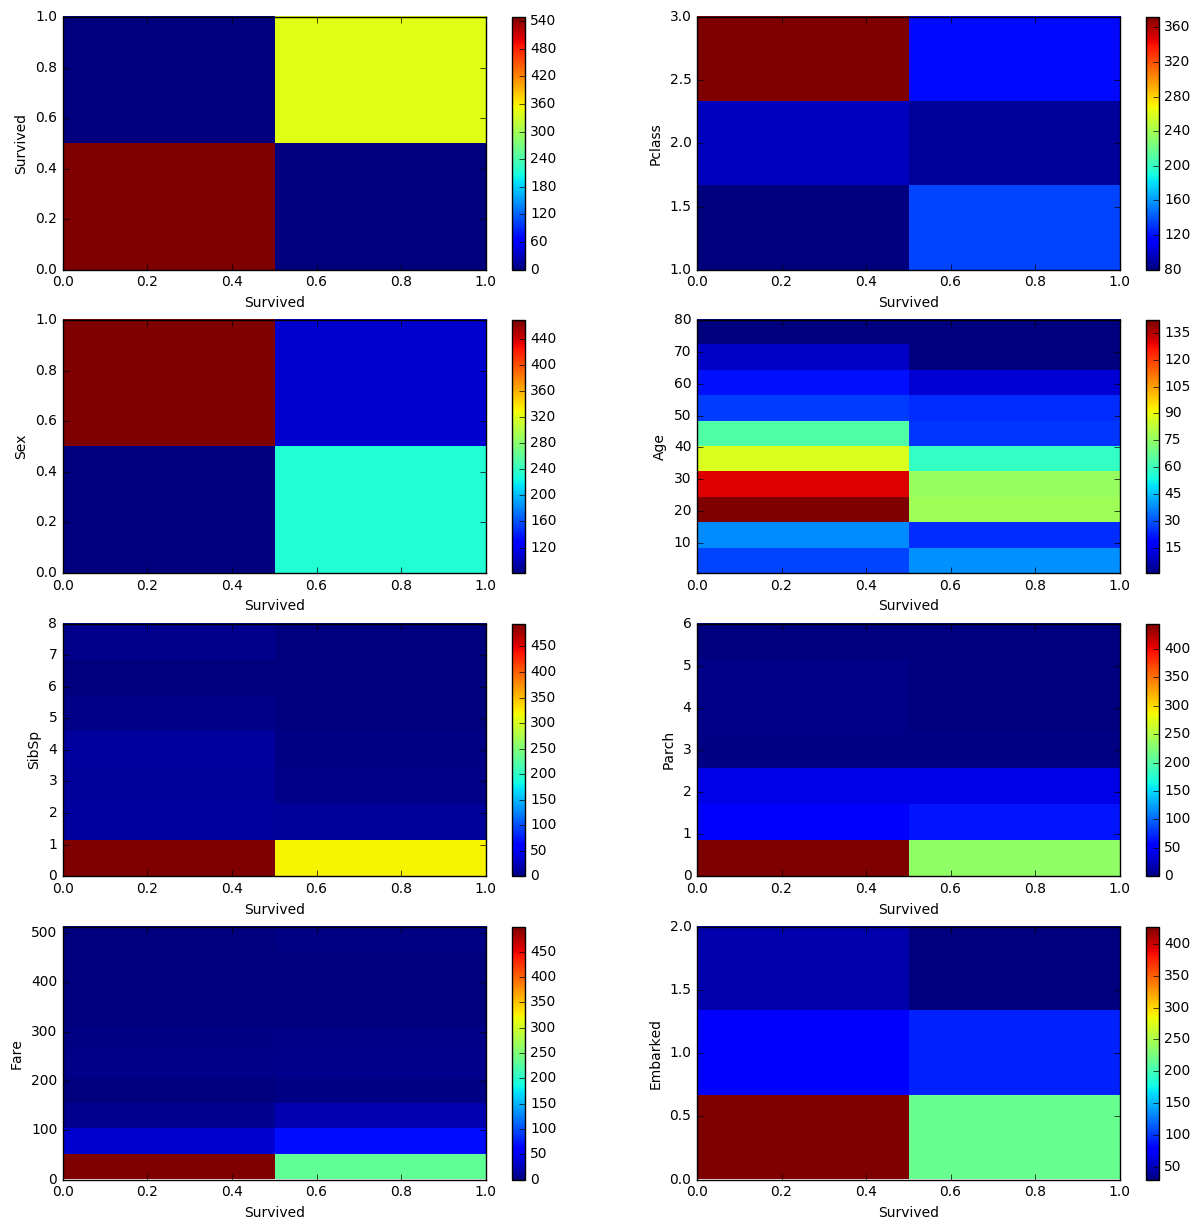

In [280]:
# plot some correlations

#from pandas.tools.plotting import scatter_matrix

#scatter_matrix(train,alpha=0.2, figsize=(15, 15), diagonal='kde')

#subres_1.hist2d(np.exp(np.ravel(myY_test[0.1]))-1,np.exp(target_prediction[input][name])-np.exp(np.ravel(myY_test[0.1])),bins=(50,50),range=((0,500),(-500,500)),cmap=plt.cm.jet)

print(train.columns)
print(train.Sex.value_counts())

f,axes= plt.subplots(4,2, figsize=(15, 15))

for i,name in enumerate([x for x in train.columns]):
    indices=(int(i/2),i%2)
    # no need to have more than 10 bins for visualization
    histo=axes[indices].hist2d(train['Survived'],train[name],bins=(2,min(len(np.unique(train[name])),10)),cmap=plt.cm.jet)
    axes[indices].set_xlabel('Survived')
    axes[indices].set_ylabel(name)
    f.colorbar(histo[3],ax=axes[indices])


[[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1ecb2b0790>


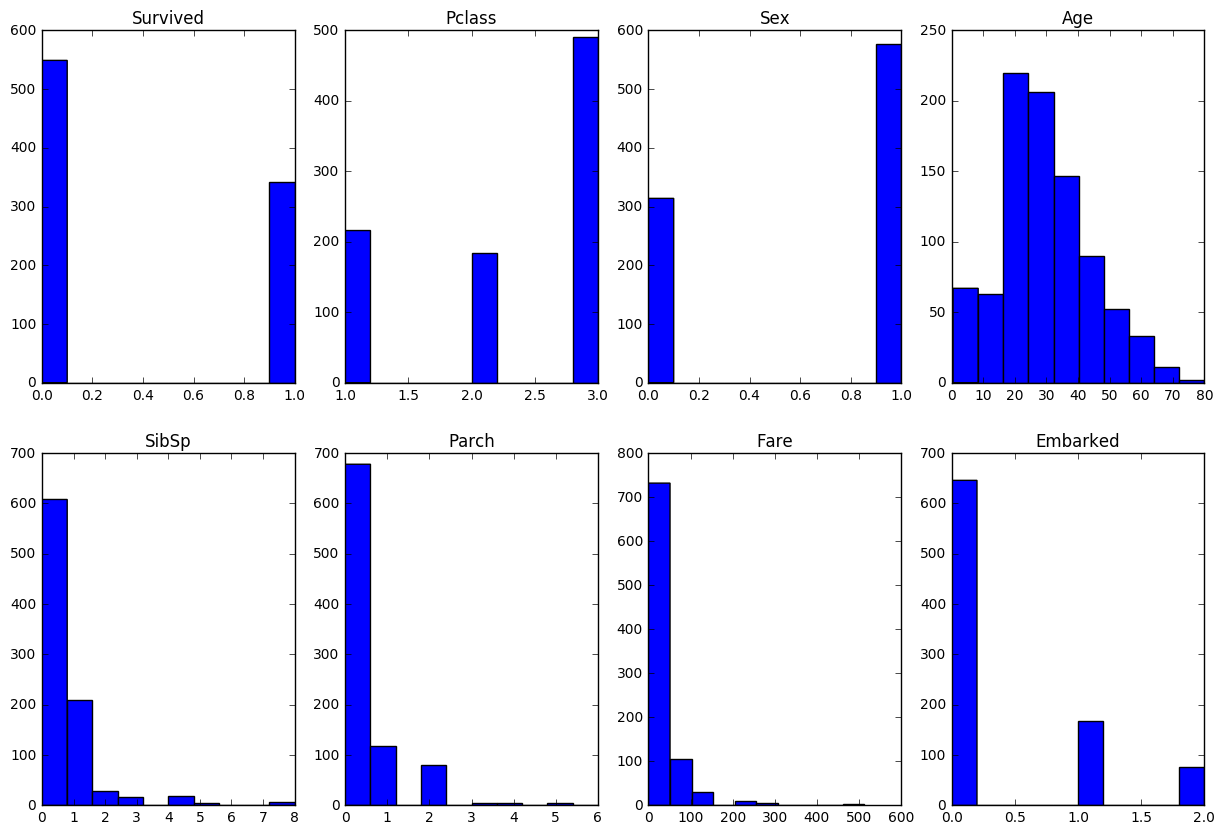

In [314]:
# A look at the distributions of the valiables in the training sample

f,ax=plt.subplots(2,4,figsize=(15,10))
print ax
for i,rowaxis in enumerate(ax):
    for j,colaxis in enumerate(rowaxis):
        colaxis.hist(train[train.columns[i*4+j]],bins=10)
        colaxis.set_title(train.columns[i*4+j])

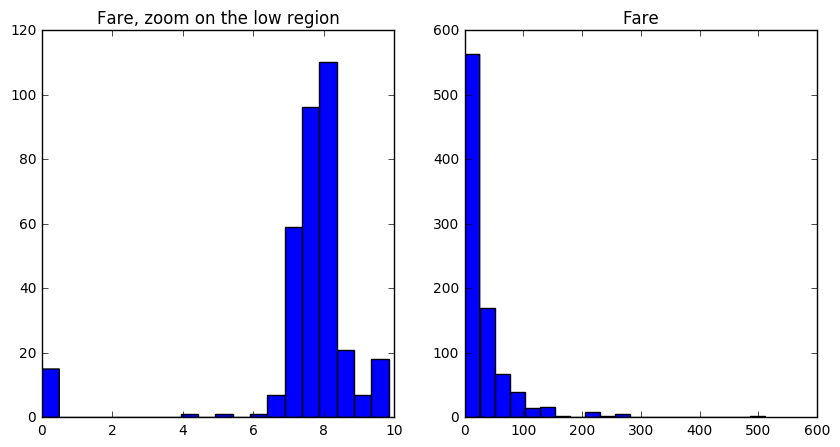

In [315]:
mask=train.Fare<10
f,ax=plt.subplots(1,2,figsize=(10,5))

ax[0].hist(train.loc[mask,'Fare'],bins=20)
ax[0].set_title('Fare, zoom on the low region')
ax[1].hist(train.loc[:,'Fare'],bins=20)
ax[1].set_title('Fare')


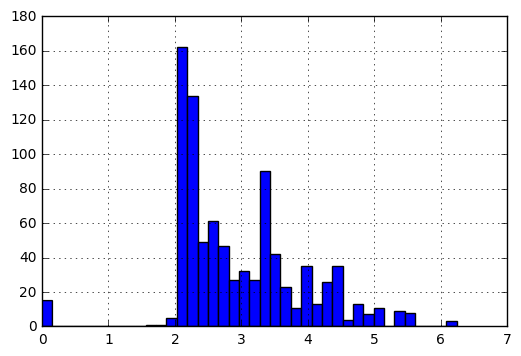

In [327]:
# the fare is peaked at low values with a long tail.
# transform it to log to obtain a smoother shape
logFare=np.log(train.Fare+1)
logFare.hist(bins=40)

# the Fare in the test has a nan. fill it with average
test['Fare'].fillna(inplace=True,value=test['Fare'].mean())

logFaretest=np.log(test.Fare+1)

In [329]:
#looks ok, let's add it to the dataset and remove the old Fare
train['LogFare']=logFare
test['LogFare']=logFaretest

#display(test)
#test.info()

In [330]:
del train['Fare']
del test['Fare']

In [331]:
#create  parallel datasets with categoricals
# Index([u'Survived', u'Pclass', u'Sex', u'Age', u'SibSp', u'Parch', u'Fare',u'Embarked']),
train_cat=pd.get_dummies(train, columns=['Pclass','Sex','Embarked'],sparse=False)
train_cat2=pd.get_dummies(train, columns=['Pclass','Sex','Embarked','SibSp','Parch'],sparse=False)

test_cat=pd.get_dummies(test, columns=['Pclass','Sex','Embarked'],sparse=False)
test_cat2=pd.get_dummies(test, columns=['Pclass','Sex','Embarked','SibSp','Parch'],sparse=False)


In [332]:

#prepare target and features
Ytrain=train.Survived.values
Xtrain=train.drop('Survived',axis=1).values
Xtrain_cat=train_cat.drop('Survived',axis=1).values
Xtrain_cat2=train_cat2.drop('Survived',axis=1).values

# remove passengerId from features in test. already removed from train at the beginning
Xtest=test.drop('PassengerId',axis=1).values
Xtest_cat=test_cat.drop('PassengerId',axis=1).values
Xtest_cat2=test_cat2.drop('PassengerId',axis=1).values


In [292]:
# prepare a pipeline with scaler+model

pipe_logreg=Pipeline([('scaler',MinMaxScaler()),('logreg',LogisticRegression())])

# use gridsearch

grid_logreg={
    'logreg__C':[0.01,0.1,1.0,10],
}


gsearch_logreg=GridSearchCV(pipe_logreg,grid_logreg,cv=5)

dict_inputs={"plain":Xtrain,
            "cat":Xtrain_cat,
            "cat2":Xtrain_cat2}

for name,features in dict_inputs.iteritems():
    
    gsearch_logreg.fit(features,Ytrain)
    results_logreg=pd.DataFrame(gsearch_logreg.cv_results_)
    display(results_logreg[['mean_test_score','params']].head())
    print "training score logreg",name,gsearch_logreg.score(features,Ytrain)

,mean_test_score,params
0,0.716049,{u'logreg__C': 0.01}
1,0.787879,{u'logreg__C': 0.1}
2,0.785634,{u'logreg__C': 1.0}
3,0.790123,{u'logreg__C': 10}


training score logreg plain 0.796857463524


,mean_test_score,params
0,0.783389,{u'logreg__C': 0.01}
1,0.780022,{u'logreg__C': 0.1}
2,0.795735,{u'logreg__C': 1.0}
3,0.799102,{u'logreg__C': 10}


training score logreg cat2 0.802469135802


,mean_test_score,params
0,0.800224,{u'logreg__C': 0.01}
1,0.780022,{u'logreg__C': 0.1}
2,0.790123,{u'logreg__C': 1.0}
3,0.790123,{u'logreg__C': 10}


training score logreg cat 0.811447811448


In [293]:
# now let's try a random forest
pipe_forest=Pipeline([('scaler',MinMaxScaler()),('forest',RandomForestClassifier())])

grid_forest={
    'forest__n_estimators':[10,20,50,70,100,200],
    'forest__min_samples_split':[2,4,6,12,18,24],
}

gsearch_forest=GridSearchCV(pipe_forest,grid_forest,cv=5)

for name,features in dict_inputs.iteritems():
    
    gsearch_forest.fit(features,Ytrain)
    results_forest=pd.DataFrame(gsearch_forest.cv_results_)
    display(results_forest[['mean_test_score','params']])
    print "best parameters",gsearch_forest.best_params_
    print "training score forest",name,gsearch_forest.score(features,Ytrain)

,mean_test_score,params
0,0.792368,"{u'forest__n_estimators': 10, u'forest__min_samples_split': 2}"
1,0.806958,"{u'forest__n_estimators': 20, u'forest__min_samples_split': 2}"
2,0.809203,"{u'forest__n_estimators': 50, u'forest__min_samples_split': 2}"
3,0.810325,"{u'forest__n_estimators': 70, u'forest__min_samples_split': 2}"
4,0.808081,"{u'forest__n_estimators': 100, u'forest__min_samples_split': 2}"
5,0.801347,"{u'forest__n_estimators': 200, u'forest__min_samples_split': 2}"
6,0.817059,"{u'forest__n_estimators': 10, u'forest__min_samples_split': 4}"
7,0.812570,"{u'forest__n_estimators': 20, u'forest__min_samples_split': 4}"
8,0.823793,"{u'forest__n_estimators': 50, u'forest__min_samples_split': 4}"
9,0.814815,"{u'forest__n_estimators': 70, u'forest__min_samples_split': 4}"


best parameters {'forest__n_estimators': 20, 'forest__min_samples_split': 6}
training score forest plain 0.927048260382


,mean_test_score,params
0,0.799102,"{u'forest__n_estimators': 10, u'forest__min_samples_split': 2}"
1,0.796857,"{u'forest__n_estimators': 20, u'forest__min_samples_split': 2}"
2,0.804714,"{u'forest__n_estimators': 50, u'forest__min_samples_split': 2}"
3,0.805836,"{u'forest__n_estimators': 70, u'forest__min_samples_split': 2}"
4,0.803591,"{u'forest__n_estimators': 100, u'forest__min_samples_split': 2}"
5,0.801347,"{u'forest__n_estimators': 200, u'forest__min_samples_split': 2}"
6,0.793490,"{u'forest__n_estimators': 10, u'forest__min_samples_split': 4}"
7,0.794613,"{u'forest__n_estimators': 20, u'forest__min_samples_split': 4}"
8,0.804714,"{u'forest__n_estimators': 50, u'forest__min_samples_split': 4}"
9,0.806958,"{u'forest__n_estimators': 70, u'forest__min_samples_split': 4}"


best parameters {'forest__n_estimators': 20, 'forest__min_samples_split': 6}
training score forest cat2 0.911335578002


,mean_test_score,params
0,0.806958,"{u'forest__n_estimators': 10, u'forest__min_samples_split': 2}"
1,0.812570,"{u'forest__n_estimators': 20, u'forest__min_samples_split': 2}"
2,0.803591,"{u'forest__n_estimators': 50, u'forest__min_samples_split': 2}"
3,0.806958,"{u'forest__n_estimators': 70, u'forest__min_samples_split': 2}"
4,0.805836,"{u'forest__n_estimators': 100, u'forest__min_samples_split': 2}"
5,0.805836,"{u'forest__n_estimators': 200, u'forest__min_samples_split': 2}"
6,0.799102,"{u'forest__n_estimators': 10, u'forest__min_samples_split': 4}"
7,0.806958,"{u'forest__n_estimators': 20, u'forest__min_samples_split': 4}"
8,0.818182,"{u'forest__n_estimators': 50, u'forest__min_samples_split': 4}"
9,0.824916,"{u'forest__n_estimators': 70, u'forest__min_samples_split': 4}"


best parameters {'forest__n_estimators': 70, 'forest__min_samples_split': 4}
training score forest cat 0.952861952862


In [294]:
# a look at MLP

pipe_mlp=Pipeline([('scaler',MinMaxScaler()),('mlp',MLPClassifier())])

grid_mlp={
    'mlp__hidden_layer_sizes':[(100, ),(100,50),(50,50),(50,25,25),(25,25,25,25)],
    'mlp__alpha':[0.00001,0.0001,0.001,0.01],
}


gsearch_mlp=GridSearchCV(pipe_mlp,grid_mlp,cv=5)

for name,features in dict_inputs.iteritems():
    
    gsearch_mlp.fit(features,Ytrain)
    results_mlp=pd.DataFrame(gsearch_mlp.cv_results_)
    display(results_mlp[['mean_test_score','params']])
    print "best parameters",gsearch_mlp.best_params_
    print "training score mlp",name,gsearch_mlp.score(features,Ytrain)

,mean_test_score,params
0,0.814815,"{u'mlp__hidden_layer_sizes': (100,), u'mlp__alpha': 1e-05}"
1,0.810325,"{u'mlp__hidden_layer_sizes': (100, 50), u'mlp__alpha': 1e-05}"
2,0.805836,"{u'mlp__hidden_layer_sizes': (50, 50), u'mlp__alpha': 1e-05}"
3,0.800224,"{u'mlp__hidden_layer_sizes': (50, 25, 25), u'mlp__alpha': 1e-05}"
4,0.802469,"{u'mlp__hidden_layer_sizes': (25, 25, 25, 25), u'mlp__alpha': 1e-05}"
5,0.815937,"{u'mlp__hidden_layer_sizes': (100,), u'mlp__alpha': 0.0001}"
6,0.809203,"{u'mlp__hidden_layer_sizes': (100, 50), u'mlp__alpha': 0.0001}"
7,0.812570,"{u'mlp__hidden_layer_sizes': (50, 50), u'mlp__alpha': 0.0001}"
8,0.796857,"{u'mlp__hidden_layer_sizes': (50, 25, 25), u'mlp__alpha': 0.0001}"
9,0.802469,"{u'mlp__hidden_layer_sizes': (25, 25, 25, 25), u'mlp__alpha': 0.0001}"


best parameters {'mlp__hidden_layer_sizes': (100,), 'mlp__alpha': 0.0001}
training score mlp plain 0.811447811448


,mean_test_score,params
0,0.795735,"{u'mlp__hidden_layer_sizes': (100,), u'mlp__alpha': 1e-05}"
1,0.806958,"{u'mlp__hidden_layer_sizes': (100, 50), u'mlp__alpha': 1e-05}"
2,0.802469,"{u'mlp__hidden_layer_sizes': (50, 50), u'mlp__alpha': 1e-05}"
3,0.804714,"{u'mlp__hidden_layer_sizes': (50, 25, 25), u'mlp__alpha': 1e-05}"
4,0.806958,"{u'mlp__hidden_layer_sizes': (25, 25, 25, 25), u'mlp__alpha': 1e-05}"
5,0.808081,"{u'mlp__hidden_layer_sizes': (100,), u'mlp__alpha': 0.0001}"
6,0.809203,"{u'mlp__hidden_layer_sizes': (100, 50), u'mlp__alpha': 0.0001}"
7,0.803591,"{u'mlp__hidden_layer_sizes': (50, 50), u'mlp__alpha': 0.0001}"
8,0.809203,"{u'mlp__hidden_layer_sizes': (50, 25, 25), u'mlp__alpha': 0.0001}"
9,0.803591,"{u'mlp__hidden_layer_sizes': (25, 25, 25, 25), u'mlp__alpha': 0.0001}"


best parameters {'mlp__hidden_layer_sizes': (100, 50), 'mlp__alpha': 0.0001}
training score mlp cat2 0.850729517396


,mean_test_score,params
0,0.796857,"{u'mlp__hidden_layer_sizes': (100,), u'mlp__alpha': 1e-05}"
1,0.800224,"{u'mlp__hidden_layer_sizes': (100, 50), u'mlp__alpha': 1e-05}"
2,0.803591,"{u'mlp__hidden_layer_sizes': (50, 50), u'mlp__alpha': 1e-05}"
3,0.805836,"{u'mlp__hidden_layer_sizes': (50, 25, 25), u'mlp__alpha': 1e-05}"
4,0.806958,"{u'mlp__hidden_layer_sizes': (25, 25, 25, 25), u'mlp__alpha': 1e-05}"
5,0.797980,"{u'mlp__hidden_layer_sizes': (100,), u'mlp__alpha': 0.0001}"
6,0.810325,"{u'mlp__hidden_layer_sizes': (100, 50), u'mlp__alpha': 0.0001}"
7,0.794613,"{u'mlp__hidden_layer_sizes': (50, 50), u'mlp__alpha': 0.0001}"
8,0.799102,"{u'mlp__hidden_layer_sizes': (50, 25, 25), u'mlp__alpha': 0.0001}"
9,0.804714,"{u'mlp__hidden_layer_sizes': (25, 25, 25, 25), u'mlp__alpha': 0.0001}"


best parameters {'mlp__hidden_layer_sizes': (100, 50), 'mlp__alpha': 0.0001}
training score mlp cat 0.837261503928


In [295]:
# last, a Kneighbors classifier

pipe_knc=Pipeline([('scaler',MinMaxScaler()),('knc',KNeighborsClassifier())])

grid_knc={
    'knc__n_neighbors':[4,5,6,7],
    'knc__weights':['distance','uniform'],
}


gsearch_knc=GridSearchCV(pipe_knc,grid_knc,cv=5)

for name,features in dict_inputs.iteritems():
    
    gsearch_knc.fit(features,Ytrain)
    results_knc=pd.DataFrame(gsearch_knc.cv_results_)
    display(results_knc[['mean_test_score','params']])
    print "best parameters",gsearch_knc.best_params_
    print "training score knc",name,gsearch_knc.score(features,Ytrain)

,mean_test_score,params
0,0.783389,"{u'knc__n_neighbors': 4, u'knc__weights': u'distance'}"
1,0.810325,"{u'knc__n_neighbors': 4, u'knc__weights': u'uniform'}"
2,0.793490,"{u'knc__n_neighbors': 5, u'knc__weights': u'distance'}"
3,0.818182,"{u'knc__n_neighbors': 5, u'knc__weights': u'uniform'}"
4,0.797980,"{u'knc__n_neighbors': 6, u'knc__weights': u'distance'}"
5,0.812570,"{u'knc__n_neighbors': 6, u'knc__weights': u'uniform'}"
6,0.795735,"{u'knc__n_neighbors': 7, u'knc__weights': u'distance'}"
7,0.810325,"{u'knc__n_neighbors': 7, u'knc__weights': u'uniform'}"


best parameters {'knc__n_neighbors': 5, 'knc__weights': 'uniform'}
training score knc plain 0.851851851852


,mean_test_score,params
0,0.781145,"{u'knc__n_neighbors': 4, u'knc__weights': u'distance'}"
1,0.806958,"{u'knc__n_neighbors': 4, u'knc__weights': u'uniform'}"
2,0.785634,"{u'knc__n_neighbors': 5, u'knc__weights': u'distance'}"
3,0.805836,"{u'knc__n_neighbors': 5, u'knc__weights': u'uniform'}"
4,0.795735,"{u'knc__n_neighbors': 6, u'knc__weights': u'distance'}"
5,0.796857,"{u'knc__n_neighbors': 6, u'knc__weights': u'uniform'}"
6,0.787879,"{u'knc__n_neighbors': 7, u'knc__weights': u'distance'}"
7,0.794613,"{u'knc__n_neighbors': 7, u'knc__weights': u'uniform'}"


best parameters {'knc__n_neighbors': 4, 'knc__weights': 'uniform'}
training score knc cat2 0.855218855219


,mean_test_score,params
0,0.787879,"{u'knc__n_neighbors': 4, u'knc__weights': u'distance'}"
1,0.811448,"{u'knc__n_neighbors': 4, u'knc__weights': u'uniform'}"
2,0.794613,"{u'knc__n_neighbors': 5, u'knc__weights': u'distance'}"
3,0.815937,"{u'knc__n_neighbors': 5, u'knc__weights': u'uniform'}"
4,0.799102,"{u'knc__n_neighbors': 6, u'knc__weights': u'distance'}"
5,0.811448,"{u'knc__n_neighbors': 6, u'knc__weights': u'uniform'}"
6,0.793490,"{u'knc__n_neighbors': 7, u'knc__weights': u'distance'}"
7,0.808081,"{u'knc__n_neighbors': 7, u'knc__weights': u'uniform'}"


best parameters {'knc__n_neighbors': 5, 'knc__weights': 'uniform'}
training score knc cat 0.854096520763


In [333]:
# and the winner is...
# random forest with _cat inputs, 'forest__n_estimators': 70, 'forest__min_samples_split': 4}
grid_forest={
    'forest__n_estimators':[70],
    'forest__min_samples_split':[4],
}

gsearch_forest=GridSearchCV(pipe_forest,grid_forest,cv=5)

gsearch_forest.fit(Xtrain_cat,Ytrain)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('forest', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'forest__n_estimators': [70], 'forest__min_samples_split': [4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [334]:
gsearch_forest.score(Xtrain_cat,Ytrain)

0.95735129068462399

In [337]:
result=gsearch_forest.predict(Xtest_cat)

submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": result
    })
submission.to_csv('titanic.csv', index=False)
